## Requirements

In [1755]:
%%capture
!pip3 install --upgrade pandas
!pip3 install albumentations
!pip3 install textaugment
!pip3 install bleu
!pip3 install rouge_score

In [1996]:
import pandas as pd
import os
import numpy as np
import gdown
import shutil
from rouge_score import rouge_scorer
import re
import shutil
from itertools import chain
from PIL import Image
import warnings
from tqdm.auto import tqdm
import math
import torch
from torchvision import transforms
from albumentations.augmentations.transforms import RandomShadow
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import nltk
from torchmetrics.text.rouge import ROUGEScore
from pprint import pprint
from bleu import list_bleu
from textaugment import EDA
from IPython.display import display, Math
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikitaligostaev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nikitaligostaev/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [1757]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [1758]:
# %cd /content/drive/MyDrive/LaTeXiM

In [1759]:
# shutil.unpack_archive('formula_images.zip', '/content/', 'zip')

In [1760]:
# shutil.unpack_archive('im2latex_dataset_map.df.pkl.zip', '/content/', 'zip')

## Data processing

In [1761]:
df = pd.read_pickle('im2latex_dataset_map.df.pkl')
df['latex'] = '$ ' + df['latex']
df

,image,formula_name,latex
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,$ \int _ { - \epsilon } ^ { \infty } d l \: \m...
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,$ d s ^ { 2 } = ( 1 - { \frac { q c o s \theta...
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,$ \widetilde \gamma _ { \mathrm { h o p f } } ...
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"$ ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \..."
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,$ S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ ...
...,...,...,...
154939,bdf0210244a0cd3_basic.png,bdf0210244a0cd3_basic,"$ D _ { g } ^ { g } ( \xi , Y ) | _ { D L } = ..."
154940,f09875fed00506d_basic.png,f09875fed00506d_basic,$ \left( \begin{array} { l l } { M _ { \tilde ...
154941,0d49cda875fc56c_basic.png,0d49cda875fc56c_basic,$ g ^ { 4 } \int { \frac { d ^ { 4 } p } { ( 2...
154942,db23b0939638460_basic.png,db23b0939638460_basic,$ E ( R ) \! = \! 2 \pi \! \! \int _ { 0 } ^ {...


In [1762]:
plt.style.use('stylesheet.mplstyle')

In [1913]:
image_folder = 'formula_images'

def draw_formula(image_name, image_folder):
    img = Image.open(os.path.join(image_folder, image_name))

    fig, ax = plt.subplots()
    ax.imshow(img, cmap = 'gray')
    ax.set_xlabel('width [px]')
    ax.set_ylabel('height [px]') 

    plt.savefig(f'{image_name}.png', dpi = 300) 

    return img

In [1764]:
df.iloc[0].image

'23be72ded29e9b4_basic.png'

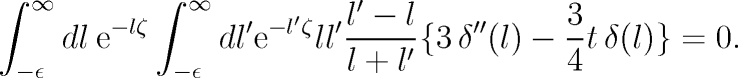

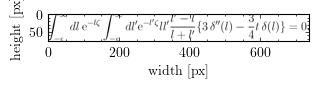

In [1765]:
draw_formula(df.iloc[0].image, image_folder)

## Say no to duplicates

In [1766]:
df.image.unique().shape

(154384,)

In [1767]:
df_count = df.groupby('image').count()

In [1768]:
df_count

,formula_name,latex
image,,
0000a586456794e_basic.png,1,1
0000a8416b30429_basic.png,1,1
0000ca7c3d3830b_basic.png,1,1
00021a10c3d0ffc_basic.png,1,1
00023a693c76183_basic.png,1,1
...,...,...
fffe86c25ec8f95_basic.png,1,1
fffec3c465bdf62_basic.png,1,1
fffef2a6b90bf2e_basic.png,1,1


In [1769]:
df_count[df_count.latex > 1]

,formula_name,latex
image,,
00fc156de50f866_basic.png,2,2
0430a433de544b3_basic.png,2,2
04e34d5221837f8_basic.png,2,2
056317ed3945572_basic.png,2,2
0571773f51af1bc_basic.png,2,2
...,...,...
fc88fb0aedf0919_basic.png,2,2
fd1691aa5f16acf_basic.png,2,2
fd86e62468a5bcf_basic.png,2,2


In [1770]:
duplicates = df_count[df_count.latex > 1].index.values.tolist()
duplicates[ : 5]

['00fc156de50f866_basic.png',
 '0430a433de544b3_basic.png',
 '04e34d5221837f8_basic.png',
 '056317ed3945572_basic.png',
 '0571773f51af1bc_basic.png']

In [1771]:
df.image.iloc[61029]

'00fc156de50f866_basic.png'

In [1772]:
df.image.iloc[36696]

'00fc156de50f866_basic.png'

In [1773]:
len(duplicates)

537

In [1774]:
indexes = []
for image in duplicates:
    img_idx = df[df.image == image].index.values.tolist()
    indexes.append(img_idx[1 : ])

In [1775]:
indexes = list(chain.from_iterable(indexes))

In [1776]:
df_pure = df.drop(index = indexes)
df_pure = df_pure.reset_index(drop = True)
df_pure

,image,formula_name,latex
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,$ \int _ { - \epsilon } ^ { \infty } d l \: \m...
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,$ d s ^ { 2 } = ( 1 - { \frac { q c o s \theta...
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,$ \widetilde \gamma _ { \mathrm { h o p f } } ...
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"$ ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \..."
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,$ S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ ...
...,...,...,...
154379,bdf0210244a0cd3_basic.png,bdf0210244a0cd3_basic,"$ D _ { g } ^ { g } ( \xi , Y ) | _ { D L } = ..."
154380,f09875fed00506d_basic.png,f09875fed00506d_basic,$ \left( \begin{array} { l l } { M _ { \tilde ...
154381,0d49cda875fc56c_basic.png,0d49cda875fc56c_basic,$ g ^ { 4 } \int { \frac { d ^ { 4 } p } { ( 2...
154382,db23b0939638460_basic.png,db23b0939638460_basic,$ E ( R ) \! = \! 2 \pi \! \! \int _ { 0 } ^ {...


## Additional: augment formula

In [1629]:
def augment_formula(df):
    
    augmneted_list = []
    
    for i in range(df.shape[0]):

        formula = df.latex.values[i]

        # delete
        t = EDA()
        augmented_formula = t.random_deletion(formula, p = 0.2)
        augmented_formula = str(augmented_formula)

        # POS tagging
        t = Wordnet()
        augmented_formula = t.augment(augmented_formula)
        augmented_formula = str(augmented_formula)

        # Random swap
        t = EDA()
        t.random_swap(augmented_formula)
        augmented_formula = str(augmented_formula)

        # Random insertion
        t = EDA()
        t.random_insertion(augmented_formula)
        augmented_formula = str(augmented_formula)

        augmneted_list.append(augmented_formula)
        
    return augmneted_list

In [1631]:
aug_list = augment_formula(df_pure)

In [905]:
df_pure['aug_latex'] = pd.DataFrame({'latex' : aug_list})
df_pure

,image,formula_name,latex,aug_latex
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,\int _ { - \epsilon } ^ { \infty } d l \: \mat...,_ { - \epsilon } ^ { d l \: { e } ^ { \zeta } ...
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,d s ^ { 2 } = ( 1 - { \frac { q c o s \theta }...,s ^ { 2 } = ( { \frac { c o s \theta } } } ) ^...
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,\widetilde \gamma _ { \mathrm { h o p f } } \s...,\gamma _ { \mathrm { h o } } \simeq _ { n > 0 ...
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \...","{ \cal l } _ { a ) _ { j } = 0 , \ \ ( { \cal ..."
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...,_ { s t a t } \pi \sqrt { _ { 5 } ^ 1 ) } n _ ...
...,...,...,...,...
154379,bdf0210244a0cd3_basic.png,bdf0210244a0cd3_basic,"D _ { g } ^ { g } ( \xi , Y ) | _ { D L } = \b...","_ { g } ^ { g \xi , y | _ { d l \beta ^ { 2 } ..."
154380,f09875fed00506d_basic.png,f09875fed00506d_basic,\left( \begin{array} { l l } { M _ { \tilde { ...,\begin{array} { l l } { m \tilde { q _ { l } }...
154381,0d49cda875fc56c_basic.png,0d49cda875fc56c_basic,g ^ { 4 } \int { \frac { d ^ { 4 } p } { ( 2 \...,^ { 4 } \int { \frac ^ { 4 p } { ( 2 ^ { 4 } }...
154382,db23b0939638460_basic.png,db23b0939638460_basic,E ( R ) \! = \! 2 \pi \! \! \int _ { 0 } ^ { \...,( r ) \! = \! 2 \! \int _ 0 } ^ { \infty \! \!...


## Add info to df

In [1777]:
def add_info_to_df(df, image_folder):
    width, height, formula_len = [], [], []

    for _, row in df.iterrows():
        image_name = row.image
        img = Image.open(os.path.join(image_folder, image_name))

        width.append(img.size[0])
        height.append(img.size[1])
        formula_len.append(len(row.latex))

    df = df.assign(width = width, height = height, formula_len = formula_len)

    return df

In [1778]:
df_pure = add_info_to_df(df_pure, image_folder)

In [1779]:
df_pure

,image,formula_name,latex,width,height,formula_len
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,$ \int _ { - \epsilon } ^ { \infty } d l \: \m...,738,78,333
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,$ d s ^ { 2 } = ( 1 - { \frac { q c o s \theta...,962,94,328
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,$ \widetilde \gamma _ { \mathrm { h o p f } } ...,291,87,144
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"$ ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \...",405,35,93
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,$ S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ ...,521,60,151
...,...,...,...,...,...,...
154379,bdf0210244a0cd3_basic.png,bdf0210244a0cd3_basic,"$ D _ { g } ^ { g } ( \xi , Y ) | _ { D L } = ...",1010,83,311
154380,f09875fed00506d_basic.png,f09875fed00506d_basic,$ \left( \begin{array} { l l } { M _ { \tilde ...,1131,100,607
154381,0d49cda875fc56c_basic.png,0d49cda875fc56c_basic,$ g ^ { 4 } \int { \frac { d ^ { 4 } p } { ( 2...,1200,88,469
154382,db23b0939638460_basic.png,db23b0939638460_basic,$ E ( R ) \! = \! 2 \pi \! \! \int _ { 0 } ^ {...,1200,100,675


In [1780]:
df_pure.sort_values(['formula_len', 'height'], ascending = [False, False])

,image,formula_name,latex,width,height,formula_len
51689,5e043be457a6ba8_basic.png,5e043be457a6ba8_basic,$ \begin{array} { l c l } { B _ { A ^ { \prime...,1020,644,2179
14840,2a166a0a8bb1481_basic.png,2a166a0a8bb1481_basic,$ \left( \begin{array} { c c c c c c c c c c c...,846,638,2152
72298,fa62f0fedf7f2e8_basic.png,fa62f0fedf7f2e8_basic,$ \left( \begin{array} { c c c c c c c c c c c...,846,638,2152
50016,054975018bca5c4_basic.png,054975018bca5c4_basic,$ \left( \begin{array} { c c c c c c c c c c c...,764,638,2144
3776,51438355bace50c_basic.png,51438355bace50c_basic,$ \begin{array} { | c c c c c c c c | c c c c ...,705,687,1905
...,...,...,...,...,...,...
64728,c1dfd96eea8cc2b_basic.png,c1dfd96eea8cc2b_basic,$ 6,14,23,3
75121,e0184adedf913b0_basic.png,e0184adedf913b0_basic,$ E,24,23,3
83430,1b6453892473a46_basic.png,1b6453892473a46_basic,$ 4,15,23,3
1106,da4b9237bacccdf_basic.png,da4b9237bacccdf_basic,$ 2,13,22,3


In [1781]:
biggest_img_id = 51689

In [1782]:
smallest_img_id = 32497

In [1783]:
average_img_id = biggest_img_id // 2

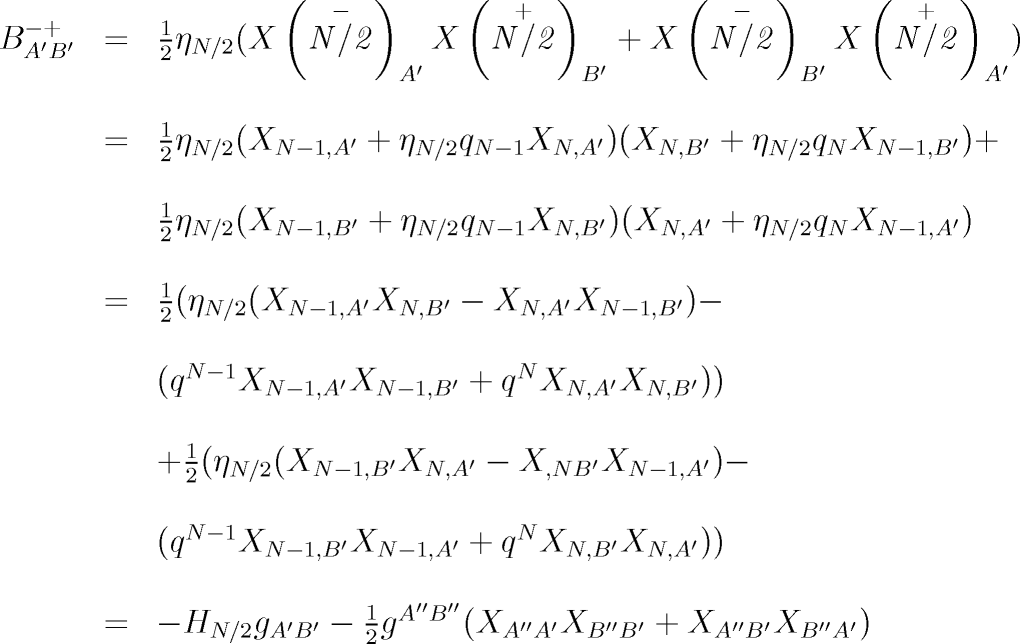

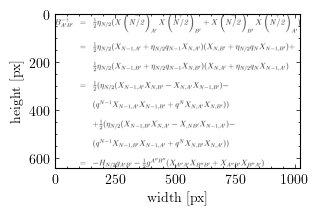

In [1784]:
draw_formula(df_pure.iloc[biggest_img_id].image, image_folder)

In [1785]:
df_pure.iloc[biggest_img_id].latex

'$ \\begin{array} { l c l } { B _ { A ^ { \\prime } B ^ { \\prime } } ^ { - + } } & { = } & { \\frac { 1 } { 2 } \\eta _ { N / 2 } ( X \\left( \\stackrel { - } { \\mathrm { \\scriptsize \\it { N / 2 } } } \\right) _ { A ^ { \\prime } } X \\left( \\stackrel { + } { \\mathrm { \\scriptsize \\it { N / 2 } } } \\right) _ { B ^ { \\prime } } + X \\left( \\stackrel { - } { \\mathrm { \\scriptsize \\it { N / 2 } } } \\right) _ { B ^ { \\prime } } X \\left( \\stackrel { + } { \\mathrm { \\scriptsize \\it { N / 2 } } } \\right) _ { A ^ { \\prime } } ) } \\\\ { } & { } & { } \\\\ { } & { = } & { \\frac { 1 } { 2 } \\eta _ { N / 2 } ( X _ { N - 1 , A ^ { \\prime } } + \\eta _ { N / 2 } q _ { N - 1 } X _ { N , A ^ { \\prime } } ) ( X _ { N , B ^ { \\prime } } + \\eta _ { N / 2 } q _ { N } X _ { N - 1 , B ^ { \\prime } } ) + } \\\\ { } & { } & { } \\\\ { } & { } & { \\frac { 1 } { 2 } \\eta _ { N / 2 } ( X _ { N - 1 , B ^ { \\prime } } + \\eta _ { N / 2 } q _ { N - 1 } X _ { N , B ^ { \\prime } } )

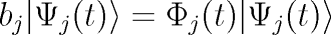

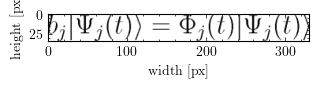

In [1786]:
draw_formula(df_pure.iloc[average_img_id].image, image_folder)

In [1787]:
df_pure.iloc[average_img_id].latex

'$ b _ { j } | \\Psi _ { j } ( t ) \\rangle = \\Phi _ { j } ( t ) | \\Psi _ { j } ( t ) \\rangle'

## Additional: generate image for augmented formula

In [1938]:
tex = 'F ( \\mathbf { x } ) = R ^ { - 2 } \\: f \\left( { \\frac { | \\mathbf { x } | } { R } } \\right) \\equiv R ^ { - 2 } f ( u )'

In [1940]:
import matplotlib.pyplot as plt
import io
from PIL import Image, ImageChops

white = (255, 255, 255, 255)

def latex_to_img(tex):
    buf = io.BytesIO()
    plt.rc('text', usetex = True)
    plt.rc('font', family = 'serif')
    plt.axis('off')
    plt.text(0.05, 0.5, f'${tex}$', size = 20)
    plt.savefig(buf, format = 'png')
    plt.close()

    im = Image.open(buf)
    bg = Image.new(im.mode, im.size, white)
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    
    return im.crop(bbox)

#latex_to_img(df_pure.iloc[smallest_img_id].latex).save('img.png')
latex_to_img(tex).save('img.png')

## Formula vizualization

In [1788]:
index = 2000

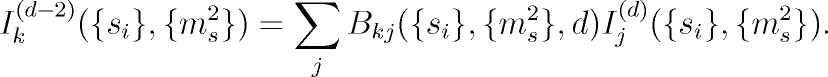

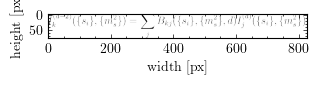

In [1789]:
draw_formula(df_pure.iloc[index].image, image_folder)

In [1790]:
df_pure.iloc[index].latex

'$ I _ { k } ^ { ( d - 2 ) } ( \\{ s _ { i } \\} , \\{ m _ { s } ^ { 2 } \\} ) = \\sum _ { j } B _ { k j } ( \\{ s _ { i } \\} , \\{ m _ { s } ^ { 2 } \\} , d ) I _ { j } ^ { ( d ) } ( \\{ s _ { i } \\} , \\{ m _ { s } ^ { 2 } \\} ) .'

In [1791]:
index = 1500

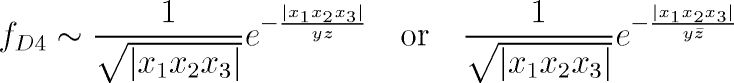

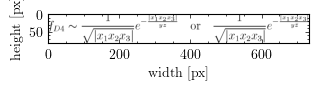

In [1792]:
draw_formula(df_pure.iloc[index].image, image_folder)

In [1793]:
df_pure.iloc[index].latex

'$ f _ { D 4 } \\sim \\frac { 1 } { \\sqrt { | x _ { 1 } x _ { 2 } x _ { 3 } | } } e ^ { - \\frac { | x _ { 1 } x _ { 2 } x _ { 3 } | } { y z } } \\quad \\mathrm { o r } \\quad \\frac { 1 } { \\sqrt { | x _ { 1 } x _ { 2 } x _ { 3 } | } } e ^ { - \\frac { | x _ { 1 } x _ { 2 } x _ { 3 } | } { y \\bar { z } } }'

In [1794]:
index = 1000

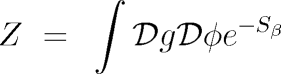

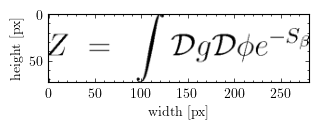

In [1795]:
draw_formula(df_pure.iloc[index].image, image_folder)

In [1796]:
df_pure.iloc[index].latex

'$ Z ~ = ~ \\int { \\cal D } g { \\cal D } \\phi e ^ { - S _ { \\beta } }'

In [1797]:
index = average_img_id

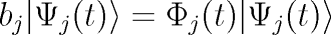

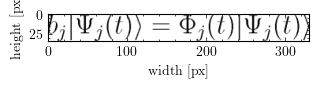

In [1798]:
draw_formula(df_pure.iloc[index].image, image_folder)

In [1799]:
df_pure.iloc[index].latex

'$ b _ { j } | \\Psi _ { j } ( t ) \\rangle = \\Phi _ { j } ( t ) | \\Psi _ { j } ( t ) \\rangle'

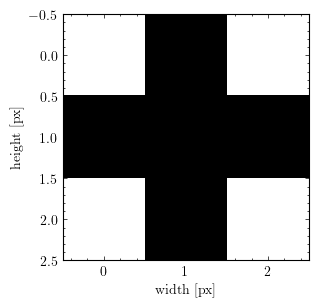

In [1800]:
draw_formula(df_pure.iloc[smallest_img_id].image, image_folder)

In [1801]:
df_pure.iloc[smallest_img_id].latex

'$ .'

In [1802]:
df_pure.latex.where(df_pure.formula_len == 1).dropna()

Series([], Name: latex, dtype: object)

In [1803]:
df_pure.width.min()

3

In [1804]:
df_pure.width.max()

1402

In [1805]:
df_pure.height.min()

3

In [1806]:
df_pure.height.max()

1489

In [1807]:
df_pure.formula_len.min()

3

In [1808]:
df_pure.formula_len.max()

2179

## Tokenize & create vocabulary

In [1809]:
def make_tokenized(df):
    str_token = df.latex.str.split(' ')
    str_tokenized_len = str_token.str.len()
    df_tokenized = df.assign(latex_tokenized = str_token, tokenized_len = str_tokenized_len)

    return df_tokenized

In [1810]:
def extract_elements(formula):
    elements = re.findall(r'\\[a-zA-Z]+|\\?[a-zA-Z]+|\S', formula)
    return elements

In [1811]:
def make_vocabulary(df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df.loc[:, 'elements'] = df['latex'].apply(extract_elements)
        
    df_vocabulary = set([element for sublist in df['elements'] for element in sublist])

    return df_vocabulary

In [1812]:
df_tokenized = make_tokenized(df_pure)

In [1813]:
df_tokenized

,image,formula_name,latex,width,height,formula_len,latex_tokenized,tokenized_len
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,$ \int _ { - \epsilon } ^ { \infty } d l \: \m...,738,78,333,"[$, \int, _, {, -, \epsilon, }, ^, {, \infty, ...",113
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,$ d s ^ { 2 } = ( 1 - { \frac { q c o s \theta...,962,94,328,"[$, d, s, ^, {, 2, }, =, (, 1, -, {, \frac, {,...",130
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,$ \widetilde \gamma _ { \mathrm { h o p f } } ...,291,87,144,"[$, \widetilde, \gamma, _, {, \mathrm, {, h, o...",52
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"$ ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \...",405,35,93,"[$, (, {, \cal, L, }, _, {, a, }, g, ), _, {, ...",44
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,$ S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ ...,521,60,151,"[$, S, _, {, s, t, a, t, }, =, 2, \pi, \sqrt, ...",62
...,...,...,...,...,...,...,...,...
154379,bdf0210244a0cd3_basic.png,bdf0210244a0cd3_basic,"$ D _ { g } ^ { g } ( \xi , Y ) | _ { D L } = ...",1010,83,311,"[$, D, _, {, g, }, ^, {, g, }, (, \xi, ,, Y, )...",96
154380,f09875fed00506d_basic.png,f09875fed00506d_basic,$ \left( \begin{array} { l l } { M _ { \tilde ...,1131,100,607,"[$, \left(, \begin{array}, {, l, l, }, {, M, _...",222
154381,0d49cda875fc56c_basic.png,0d49cda875fc56c_basic,$ g ^ { 4 } \int { \frac { d ^ { 4 } p } { ( 2...,1200,88,469,"[$, g, ^, {, 4, }, \int, {, \frac, {, d, ^, {,...",212
154382,db23b0939638460_basic.png,db23b0939638460_basic,$ E ( R ) \! = \! 2 \pi \! \! \int _ { 0 } ^ {...,1200,100,675,"[$, E, (, R, ), \!, =, \!, 2, \pi, \!, \!, \in...",225


In [1814]:
df_vocabulary = make_vocabulary(df_tokenized)
df_vocabulary.add('\,')
df_vocabulary.add('\right)')
df_vocabulary.add('\left(')
df_vocabulary.add('$')
df_vocabulary.add('<PAD>')

In [1815]:
df_vocabulary

{'\right)',
 '!',
 '"',
 '#',
 '$',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '<PAD>',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'Object',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 '\\,',
 '\\AA',
 '\\Arrowvert',
 '\\Bar',
 '\\Big',
 '\\Bigg',
 '\\Biggl',
 '\\Biggm',
 '\\Biggr',
 '\\Bigl',
 '\\Bigm',
 '\\Bigr',
 '\\Delta',
 '\\Downarrow',
 '\\Gamma',
 '\\Hat',
 '\\Huge',
 '\\Im',
 '\\L',
 '\\LARGE',
 '\\Lambda',
 '\\Large',
 '\\Leftarrow',
 '\\Leftrightarrow',
 '\\Longleftarrow',
 '\\Longleftrightarrow',
 '\\Longrightarrow',
 '\\O',
 '\\Omega',
 '\\P',
 '\\Phi',
 '\\Pi',
 '\\Psi',
 '\\Re',
 '\\Rightarrow',
 '\\S',
 '\\SS',
 '\\Sigma',
 '\\Theta',
 '\\Tilde',
 '\\Uparrow',
 '\\Upsilon',
 '\\Vec',
 '\\Vert',
 '\\Xi',
 '\\a',
 '\\acute',
 '\\ae',
 '\\aleph',
 '\\allowbreak',
 '\\alpha

In [1816]:
len(df_vocabulary)

519

In [1817]:
type(df_vocabulary)

set

In [1818]:
all_tokens = {i: token for i, token in enumerate(df_vocabulary)}
all_tokens

{0: '\\Biggl',
 1: '?',
 2: '\\rule',
 3: 'K',
 4: '\\mathsf',
 5: '\\geq',
 6: '\\varGamma',
 7: '\\textstyle',
 8: '\\pmod',
 9: '\\Omega',
 10: 'O',
 11: '\\dagger',
 12: '\\preceq',
 13: '\\Gamma',
 14: '\\textsc',
 15: '\\kappa',
 16: '\\bar',
 17: '\\,',
 18: '\\Lambda',
 19: '\\simeq',
 20: 'cm',
 21: '\\Uparrow',
 22: '\\bigotimes',
 23: '\\hss',
 24: 'ex',
 25: '\\begin',
 26: '~',
 27: '\\ij',
 28: '8',
 29: '\\vline',
 30: '\\pmb',
 31: '\\overleftarrow',
 32: '\\vec',
 33: '\\partial',
 34: '\\vee',
 35: 'Object',
 36: '\\propto',
 37: '\\triangleleft',
 38: '^',
 39: '\\underbrace',
 40: '\\special',
 41: '\\bmod',
 42: '\\mid',
 43: '\\sqcup',
 44: '\\parallel',
 45: '\\chi',
 46: '\\leftarrow',
 47: '\\Vec',
 48: '\\mathit',
 49: '+',
 50: '\\hline',
 51: '\\negthickspace',
 52: '\\llap',
 53: '\\strut',
 54: '\\Bigg',
 55: '\\tag',
 56: '\\wp',
 57: '\\def',
 58: '\\large',
 59: '\\swarrow',
 60: '\\Phi',
 61: '\\cong',
 62: ',',
 63: '\\backslash',
 64: '\\tilde',
 65:

In [1819]:
type(all_tokens)

dict

In [1820]:
tmp_id = 30

In [1821]:
df_tokenized.latex[tmp_id]

'$ S \\sim \\tilde { \\psi } Q _ { o } \\tilde { \\psi } + g _ { s } ^ { 1 / 2 } \\tilde { \\psi } ^ { 3 } + \\tilde { \\phi } Q _ { c } \\tilde { \\phi } + g _ { s } \\tilde { \\phi } ^ { 3 } + \\tilde { \\phi } B ( g _ { s } ^ { 1 / 2 } \\tilde { \\psi } ) + \\cdots .'

In [1822]:
len(df_tokenized.latex[tmp_id])

251

In [1823]:
def get_key_by_value(dictionary, value):
    
    for key, val in dictionary.items():
        if val == value:
            return key
        
    return None

In [1824]:
def encode_sequence(seq, max_length):

    vocabulary = all_tokens
    tokens = []
    for token in seq.split():
        #print(token)
        for key, value in vocabulary.items():  
            if token == value:
                tokens.append(key)
                
    if len(tokens) < max_length:
        tokens += [get_key_by_value(all_tokens, '<PAD>')] * (max_length - len(tokens))
    elif len(tokens) > max_length:
        tokens = tokens[ : max_length]
            
    return tokens

In [1825]:
max_length = 150
encoded_seq = encode_sequence(df_tokenized.latex[tmp_id], max_length)

In [1826]:
encoded_seq

[402,
 178,
 241,
 64,
 299,
 368,
 319,
 412,
 179,
 299,
 223,
 319,
 64,
 299,
 368,
 319,
 49,
 502,
 179,
 299,
 312,
 319,
 38,
 299,
 195,
 162,
 377,
 319,
 64,
 299,
 368,
 319,
 38,
 299,
 233,
 319,
 49,
 64,
 299,
 211,
 319,
 412,
 179,
 299,
 419,
 319,
 64,
 299,
 211,
 319,
 49,
 502,
 179,
 299,
 312,
 319,
 64,
 299,
 211,
 319,
 38,
 299,
 233,
 319,
 49,
 64,
 299,
 211,
 319,
 332,
 483,
 502,
 179,
 299,
 312,
 319,
 38,
 299,
 195,
 162,
 377,
 319,
 64,
 299,
 368,
 319,
 479,
 49,
 221,
 108,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84]

In [1827]:
len(encoded_seq)

150

In [1828]:
sequence = ' '.join([all_tokens[token] for token in encoded_seq])
print(sequence)

$ S \sim \tilde { \psi } Q _ { o } \tilde { \psi } + g _ { s } ^ { 1 / 2 } \tilde { \psi } ^ { 3 } + \tilde { \phi } Q _ { c } \tilde { \phi } + g _ { s } \tilde { \phi } ^ { 3 } + \tilde { \phi } B ( g _ { s } ^ { 1 / 2 } \tilde { \psi } ) + \cdots . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [1829]:
print('Input:\n', df_tokenized.latex[tmp_id])
print('Output:\n', sequence)

Input:
 $ S \sim \tilde { \psi } Q _ { o } \tilde { \psi } + g _ { s } ^ { 1 / 2 } \tilde { \psi } ^ { 3 } + \tilde { \phi } Q _ { c } \tilde { \phi } + g _ { s } \tilde { \phi } ^ { 3 } + \tilde { \phi } B ( g _ { s } ^ { 1 / 2 } \tilde { \psi } ) + \cdots .
Output:
 $ S \sim \tilde { \psi } Q _ { o } \tilde { \psi } + g _ { s } ^ { 1 / 2 } \tilde { \psi } ^ { 3 } + \tilde { \phi } Q _ { c } \tilde { \phi } + g _ { s } \tilde { \phi } ^ { 3 } + \tilde { \phi } B ( g _ { s } ^ { 1 / 2 } \tilde { \psi } ) + \cdots . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


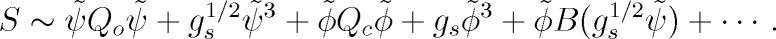

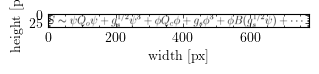

In [1830]:
draw_formula(df_tokenized.iloc[tmp_id].image, image_folder)

In [1831]:
df_tokenized_copy = df_tokenized[:6]
df_tokenized_copy

,image,formula_name,latex,width,height,formula_len,latex_tokenized,tokenized_len,elements
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,$ \int _ { - \epsilon } ^ { \infty } d l \: \m...,738,78,333,"[$, \int, _, {, -, \epsilon, }, ^, {, \infty, ...",113,"[$, \int, _, {, -, \epsilon, }, ^, {, \infty, ..."
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,$ d s ^ { 2 } = ( 1 - { \frac { q c o s \theta...,962,94,328,"[$, d, s, ^, {, 2, }, =, (, 1, -, {, \frac, {,...",130,"[$, d, s, ^, {, 2, }, =, (, 1, -, {, \frac, {,..."
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,$ \widetilde \gamma _ { \mathrm { h o p f } } ...,291,87,144,"[$, \widetilde, \gamma, _, {, \mathrm, {, h, o...",52,"[$, \widetilde, \gamma, _, {, \mathrm, {, h, o..."
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"$ ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \...",405,35,93,"[$, (, {, \cal, L, }, _, {, a, }, g, ), _, {, ...",44,"[$, (, {, \cal, L, }, _, {, a, }, g, ), _, {, ..."
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,$ S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ ...,521,60,151,"[$, S, _, {, s, t, a, t, }, =, 2, \pi, \sqrt, ...",62,"[$, S, _, {, s, t, a, t, }, =, 2, \pi, \sqrt, ..."
5,8135cab7e6b93ae_basic.png,8135cab7e6b93ae_basic,$ \hat { N } _ { 3 } = \sum \sp f _ { j = 1 } ...,206,102,86,"[$, \hat, {, N, }, _, {, 3, }, =, \sum, \sp, f...",35,"[$, \hat, {, N, }, _, {, 3, }, =, \sum, \sp, f..."


In [1832]:
df_tokenized_copy['tokens'] = df_tokenized_copy['latex'].apply(lambda x: encode_sequence(x, max_length))
df_tokenized_copy

/var/folders/6w/67xzr9g56gld38cy63k9vv_w0000gn/T/ipykernel_1327/867421444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokenized_copy['tokens'] = df_tokenized_copy['latex'].apply(lambda x: encode_sequence(x, max_length))


,image,formula_name,latex,width,height,formula_len,latex_tokenized,tokenized_len,elements,tokens
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,$ \int _ { - \epsilon } ^ { \infty } d l \: \m...,738,78,333,"[$, \int, _, {, -, \epsilon, }, ^, {, \infty, ...",113,"[$, \int, _, {, -, \epsilon, }, ^, {, \infty, ...","[402, 225, 179, 299, 247, 513, 319, 38, 299, 1..."
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,$ d s ^ { 2 } = ( 1 - { \frac { q c o s \theta...,962,94,328,"[$, d, s, ^, {, 2, }, =, (, 1, -, {, \frac, {,...",130,"[$, d, s, ^, {, 2, }, =, (, 1, -, {, \frac, {,...","[402, 185, 312, 38, 299, 377, 319, 384, 483, 1..."
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,$ \widetilde \gamma _ { \mathrm { h o p f } } ...,291,87,144,"[$, \widetilde, \gamma, _, {, \mathrm, {, h, o...",52,"[$, \widetilde, \gamma, _, {, \mathrm, {, h, o...","[402, 188, 220, 179, 299, 434, 299, 310, 223, ..."
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"$ ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \...",405,35,93,"[$, (, {, \cal, L, }, _, {, a, }, g, ), _, {, ...",44,"[$, (, {, \cal, L, }, _, {, a, }, g, ), _, {, ...","[402, 483, 299, 234, 361, 319, 179, 299, 295, ..."
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,$ S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ ...,521,60,151,"[$, S, _, {, s, t, a, t, }, =, 2, \pi, \sqrt, ...",62,"[$, S, _, {, s, t, a, t, }, =, 2, \pi, \sqrt, ...","[402, 178, 179, 299, 312, 517, 295, 517, 319, ..."
5,8135cab7e6b93ae_basic.png,8135cab7e6b93ae_basic,$ \hat { N } _ { 3 } = \sum \sp f _ { j = 1 } ...,206,102,86,"[$, \hat, {, N, }, _, {, 3, }, =, \sum, \sp, f...",35,"[$, \hat, {, N, }, _, {, 3, }, =, \sum, \sp, f...","[402, 423, 299, 391, 319, 179, 299, 233, 319, ..."


In [1833]:
df_tokenized['tokens'] = df_tokenized['latex'].apply(lambda x: encode_sequence(x, max_length))

In [1834]:
df_tokenized

,image,formula_name,latex,width,height,formula_len,latex_tokenized,tokenized_len,elements,tokens
0,23be72ded29e9b4_basic.png,23be72ded29e9b4_basic,$ \int _ { - \epsilon } ^ { \infty } d l \: \m...,738,78,333,"[$, \int, _, {, -, \epsilon, }, ^, {, \infty, ...",113,"[$, \int, _, {, -, \epsilon, }, ^, {, \infty, ...","[402, 225, 179, 299, 247, 513, 319, 38, 299, 1..."
1,8c904c5d9c7bd63_basic.png,8c904c5d9c7bd63_basic,$ d s ^ { 2 } = ( 1 - { \frac { q c o s \theta...,962,94,328,"[$, d, s, ^, {, 2, }, =, (, 1, -, {, \frac, {,...",130,"[$, d, s, ^, {, 2, }, =, (, 1, -, {, \frac, {,...","[402, 185, 312, 38, 299, 377, 319, 384, 483, 1..."
2,1f111caa1be3516_basic.png,1f111caa1be3516_basic,$ \widetilde \gamma _ { \mathrm { h o p f } } ...,291,87,144,"[$, \widetilde, \gamma, _, {, \mathrm, {, h, o...",52,"[$, \widetilde, \gamma, _, {, \mathrm, {, h, o...","[402, 188, 220, 179, 299, 434, 299, 310, 223, ..."
3,76287b1b483a0d2_basic.png,76287b1b483a0d2_basic,"$ ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \...",405,35,93,"[$, (, {, \cal, L, }, _, {, a, }, g, ), _, {, ...",44,"[$, (, {, \cal, L, }, _, {, a, }, g, ), _, {, ...","[402, 483, 299, 234, 361, 319, 179, 299, 295, ..."
4,7483d06c1e14dcb_basic.png,7483d06c1e14dcb_basic,$ S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ ...,521,60,151,"[$, S, _, {, s, t, a, t, }, =, 2, \pi, \sqrt, ...",62,"[$, S, _, {, s, t, a, t, }, =, 2, \pi, \sqrt, ...","[402, 178, 179, 299, 312, 517, 295, 517, 319, ..."
...,...,...,...,...,...,...,...,...,...,...
154379,bdf0210244a0cd3_basic.png,bdf0210244a0cd3_basic,"$ D _ { g } ^ { g } ( \xi , Y ) | _ { D L } = ...",1010,83,311,"[$, D, _, {, g, }, ^, {, g, }, (, \xi, ,, Y, )...",96,"[$, D, _, {, g, }, ^, {, g, }, (, \xi, ,, Y, )...","[402, 431, 179, 299, 502, 319, 38, 299, 502, 3..."
154380,f09875fed00506d_basic.png,f09875fed00506d_basic,$ \left( \begin{array} { l l } { M _ { \tilde ...,1131,100,607,"[$, \left(, \begin{array}, {, l, l, }, {, M, _...",222,"[$, \left, (, \begin, {, array, }, {, l, l, },...","[402, 356, 299, 139, 139, 319, 299, 397, 179, ..."
154381,0d49cda875fc56c_basic.png,0d49cda875fc56c_basic,$ g ^ { 4 } \int { \frac { d ^ { 4 } p } { ( 2...,1200,88,469,"[$, g, ^, {, 4, }, \int, {, \frac, {, d, ^, {,...",212,"[$, g, ^, {, 4, }, \int, {, \frac, {, d, ^, {,...","[402, 502, 38, 299, 111, 319, 225, 299, 151, 2..."
154382,db23b0939638460_basic.png,db23b0939638460_basic,$ E ( R ) \! = \! 2 \pi \! \! \int _ { 0 } ^ {...,1200,100,675,"[$, E, (, R, ), \!, =, \!, 2, \pi, \!, \!, \in...",225,"[$, E, (, R, ), \, !, =, \, !, 2, \pi, \, !, \...","[402, 65, 483, 381, 479, 384, 377, 202, 225, 1..."


In [1835]:
df_tokenized.to_pickle('Tokenized_df.pkl')

## Dataset

In [1836]:
class CustomDataset(object):
    def __init__(self, image_folder, transform = None):
        self.path = image_folder
        self.files = os.listdir(image_folder)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        #img = Image.open(os.path.join(self.path, self.files[idx])) 
        img = cv2.imread(os.path.join(self.path, self.files[idx]))

        if self.transform is not None:
            img = self.transform(image = img)["image"]

        return img, self.files[idx]

In [1896]:
transform = A.Compose([
        A.Resize(height = 224, width = 224),
        A.RandomBrightnessContrast(p = 0.2),
        A.RandomShadow(p = 1, num_shadows_lower = 2, 
                       num_shadows_upper = 3, shadow_dimension = 3, 
                       shadow_roi = (0, 0.5, 1, 1)),
        A.GaussianBlur(blur_limit = (3, 7), p = 0.3),
        A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
        ToTensorV2(),
])

dataset = CustomDataset(image_folder=image_folder, transform=transform)

In [1897]:
dataset[0]

(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

In [1898]:
batch_size = 32

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [1899]:
img, img_name = next(iter(val_dataloader))

In [1900]:
len(img)

32

In [1901]:
img[0][0].shape

torch.Size([224, 224])

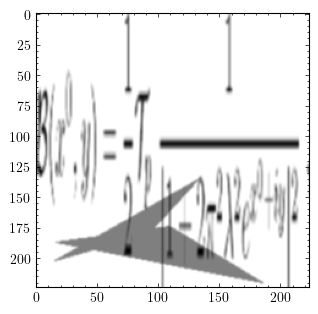

In [1902]:
plt.imshow(img[0][0], cmap = 'gray');

In [1903]:
img_name[0]

'bfeb789a678e6cc_basic.png'

In [1904]:
df_tokenized['latex'].where(df_tokenized['image'] == img_name[0]).dropna()

99025    $ { \cal B } ( x ^ { 0 } , y ) = { \frac { 1 }...
Name: latex, dtype: object

In [1905]:
def plot_random_augmented(img, img_name):

    num_images = len(img)
    random_indices = np.random.choice(num_images, size = 16, replace = False)

    fig, axes = plt.subplots(4, 4, figsize = (15, 15))

    for i, idx in enumerate(random_indices):
        image = img[idx].permute(1, 2, 0)  
        axes[i // 4, i % 4].imshow(image)
        axes[i // 4, i % 4].axis('off')
        axes[i // 4, i % 4].set_title(f'{img_name[idx]}')
    
    plt.savefig(f'stack.png', dpi = 300) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

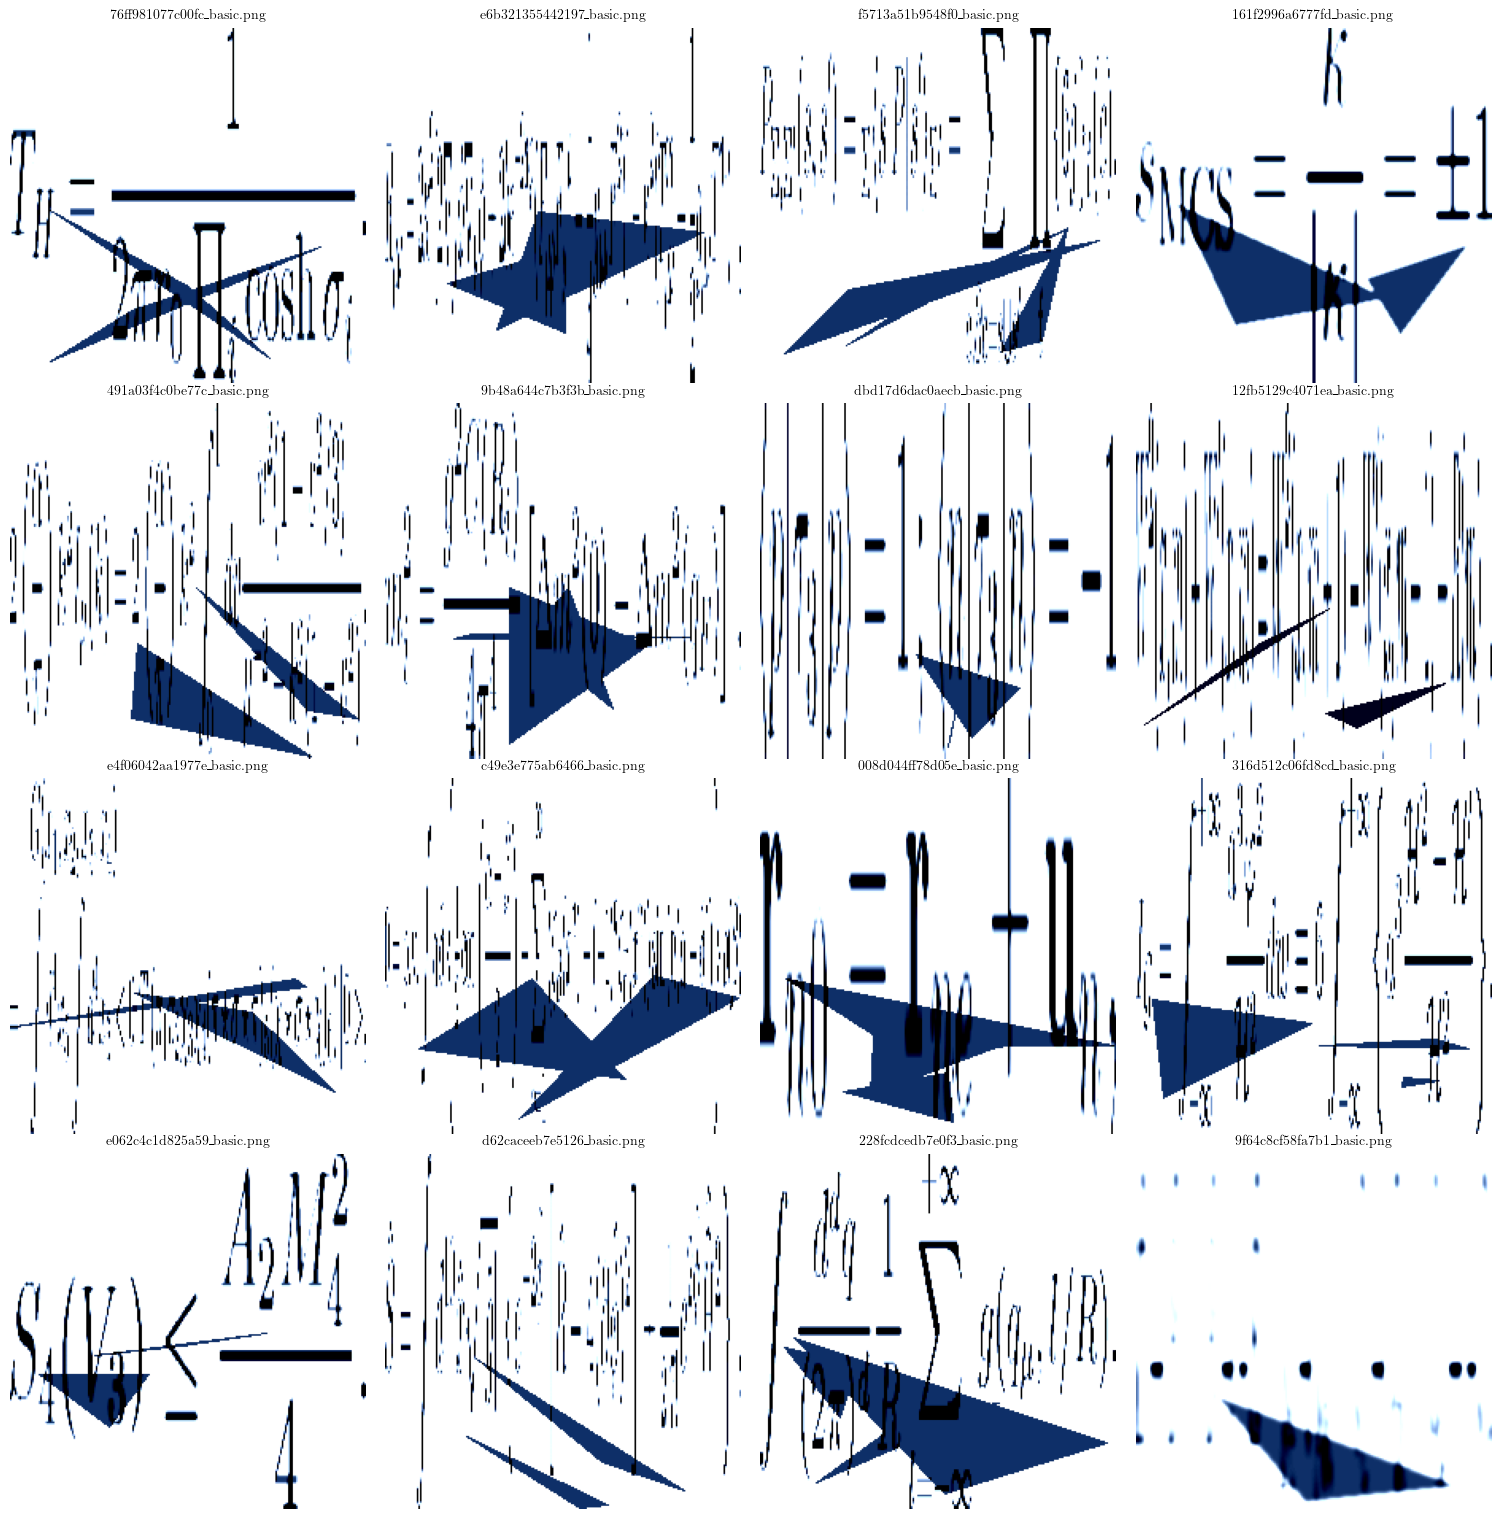

In [1906]:
plot_random_augmented(img, img_name)

In [1932]:
index = 18
image_sample = img[index][0,]
image_name = img_name[index]

In [1933]:
df_tokenized['latex'].where(df_tokenized['image'] == image_name).dropna()

139471    $ u _ { \mathrm { s c a l e d } } = \frac { 1 ...
Name: latex, dtype: object

In [1934]:
def take_formula_from_df(df):
  
    formula = df['latex'].where(df['image'] == image_name)
    formula = formula.dropna().values.tolist()
    formula = str(formula)
    formula = formula[2 : -2]
    formula = formula.replace('\\\\', '\\')
    formula

    return formula

In [1935]:
formula = take_formula_from_df(df_tokenized)

0a017120420afc7_basic.png
$ u _ { \mathrm { s c a l e d } } = \frac { 1 } { L ^ { 3 } } \langle V \rangle - \frac { 1 } { L ^ { 3 } } \langle V _ { 0 } \rangle ~ ,


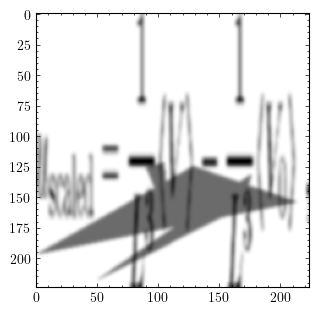

In [1936]:
plt.imshow(image_sample, cmap = 'gray')
print(image_name)
print(formula)

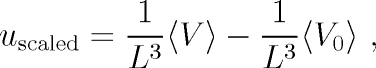

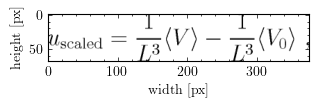

In [1937]:
draw_formula(image_name, image_folder)